In [ ]:
!pip install nilearn
!pip install tsfresh

import glob
import os
import pandas as pd
import lightgbm as lgb
import numpy as np
import seaborn as sns

from nilearn.signal import clean
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_DIR = "/content/drive/MyDrive/"
EXTRACTED_ZIP_DIR = f"./AOMIC"
TS_DIR = f"{EXTRACTED_ZIP_DIR}/TS"
NOISE_DIR = f"{EXTRACTED_ZIP_DIR}/Noise"
DATASET_FILE_SUFFIX = "_acq-seq_desc-confounds_regressors_6_motion_and_derivs.txt"
LABELS_DICT = {
    "task-restingstate": 0,
    "task-stopsignal": 1,
    "task-workingmemory": 2,
    "task-emomatching": 3,
}

In [ ]:
!unzip /content/drive/MyDrive/AOMIC.zip

Archive:  /content/drive/MyDrive/AOMIC.zip
   creating: AOMIC/
  inflating: AOMIC/.DS_Store         
  inflating: __MACOSX/AOMIC/._.DS_Store  
   creating: AOMIC/Noise/
   creating: AOMIC/TS/
  inflating: __MACOSX/AOMIC/._TS     
  inflating: AOMIC/Noise/sub-0072_task-stopsignal_acq-seq_desc-confounds_regressors_6_motion_and_derivs.txt  
  inflating: AOMIC/Noise/sub-0078_task-stopsignal_acq-seq_desc-confounds_regressors_6_motion_and_derivs.txt  
  inflating: AOMIC/Noise/sub-0131_task-emomatching_acq-seq_desc-confounds_regressors_6_motion_and_derivs.txt  
  inflating: AOMIC/Noise/sub-0157_task-stopsignal_acq-seq_desc-confounds_regressors_6_motion_and_derivs.txt  
  inflating: AOMIC/Noise/sub-0008_task-emomatching_acq-seq_desc-confounds_regressors_6_motion_and_derivs.txt  
  inflating: AOMIC/Noise/sub-0115_task-emomatching_acq-seq_desc-confounds_regressors_6_motion_and_derivs.txt  
  inflating: AOMIC/Noise/sub-0094_task-stopsignal_acq-seq_desc-confounds_regressors_6_motion_and_derivs.txt

In [ ]:
def create_dataset():
    zip_file_path = f"{DATASET_DIR}/AOMIC.zip"
    if not os.path.exists(EXTRACTED_ZIP_DIR):
        print("Extracting dataset...")
        os.system(f"unzip {zip_file_path} -d {EXTRACTED_ZIP_DIR}")

    dataset = []
    labels = []

    data_files_paths = [i for i in glob.glob(f"{TS_DIR}/sub-*.txt")]
    data_files_paths.sort()
    data_files_names = [i.split("/")[-1] for i in data_files_paths]

    for data_file_path, data_file_name in zip(data_files_paths, data_files_names):
        # load dataset element
        data = np.loadtxt(data_file_path)

        file_name_parts = data_file_name.split("_")
        data_id = "_".join(file_name_parts[:2])

        # clean the element (denoise, detrend, standardize)
        noise = np.loadtxt(f"{NOISE_DIR}/{data_id}{DATASET_FILE_SUFFIX}")
        cleaned_data = clean(data, confounds=noise, standardize=True, detrend=True)
        dataset.append(cleaned_data)

        # get label
        label_key = file_name_parts[1]
        labels.append(LABELS_DICT[label_key])

    # make all elements of the dataset the same length (some time series are longer than others)
    shortest_data_len = min([len(item) for item in dataset])
    dataset = [item[:shortest_data_len] for item in dataset]

    return np.array(dataset), np.array(labels)

In [ ]:
dataset, labels = create_dataset()

<ipython-input-5-89b0ff418d55>:23: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  cleaned_data = clean(data, confounds=noise, standardize=True, detrend=True)


In [ ]:
# element x time x features
dataset.shape

(896, 135, 200)

In [ ]:
def split(dataset, labels):
    return train_test_split(dataset, labels, test_size=0.2, random_state=42)

In [ ]:
x_train, x_test, y_train, y_test = split(dataset, labels)

In [ ]:
x_train.shape

(716, 135, 200)

In [ ]:
def create_dataframe(dataset):
  ids = np.array([[id_value] * dataset.shape[1] for id_value in range(dataset.shape[0])])
  ids = ids.reshape(-1)

  df_values = dataset.reshape(-1, dataset.shape[2])
  df = pd.DataFrame(df_values, columns=[f"region{i}" for i in range(df_values.shape[1])])
  df["ids"] = ids

  # make ids the first column
  df = df[["ids"] + [c for c in df if c not in ["ids"]]]

  return df

In [ ]:
df_train = create_dataframe(x_train)
df_test = create_dataframe(x_test)

In [ ]:
y_train[0], y_train[200], y_train[400], y_train[2]

(3, 2, 1, 0)

<Axes: >

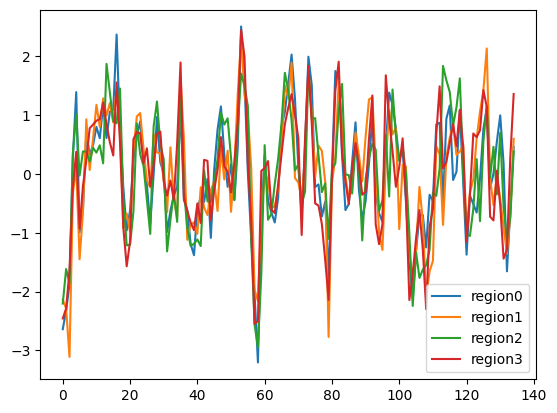

In [ ]:
df_train[df_train.ids == 0][['region0', 'region1', 'region2', 'region3']].plot()

<Axes: >

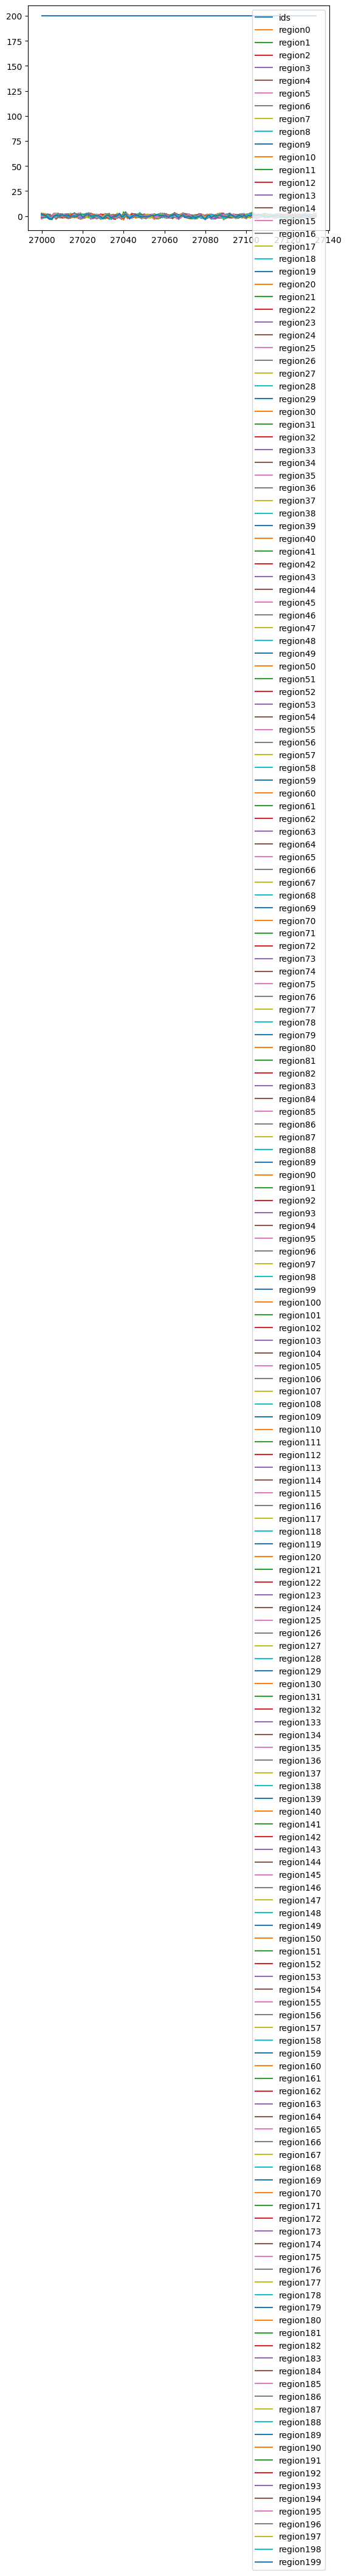

In [ ]:
df_train[df_train.ids == 200].plot()

<Axes: >

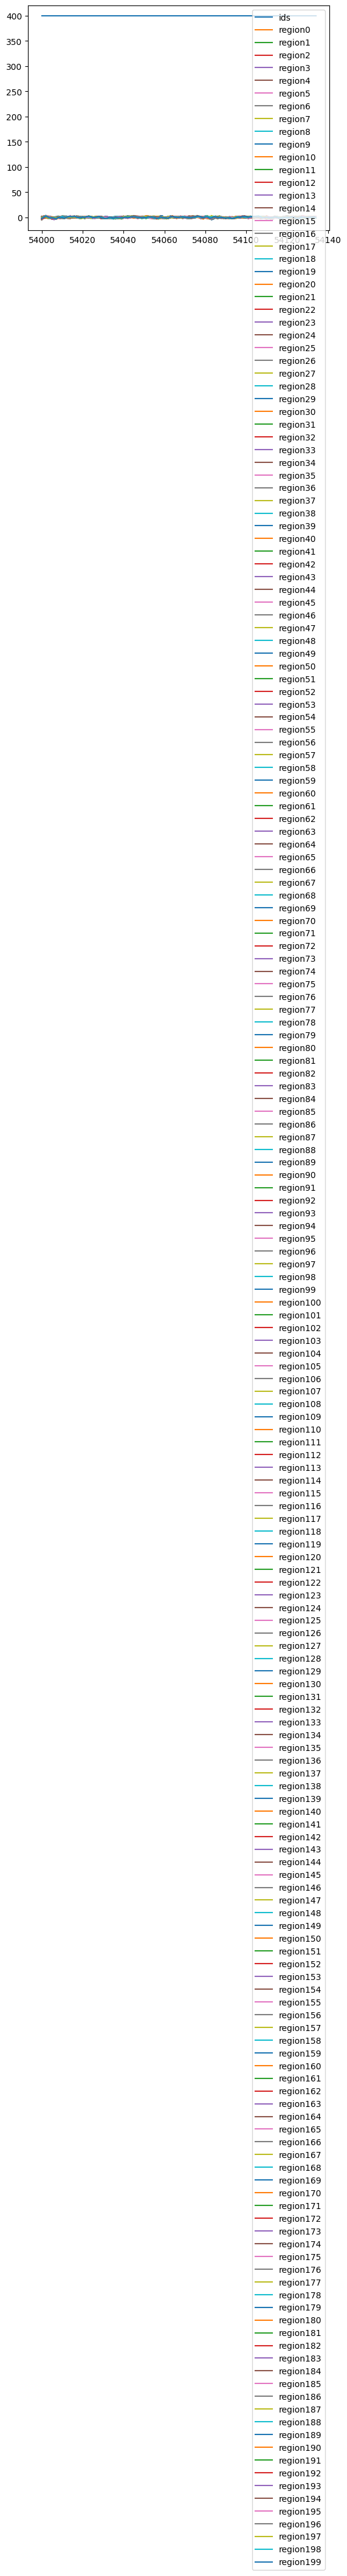

In [ ]:
df_train[df_train.ids == 400].plot()

<Axes: >

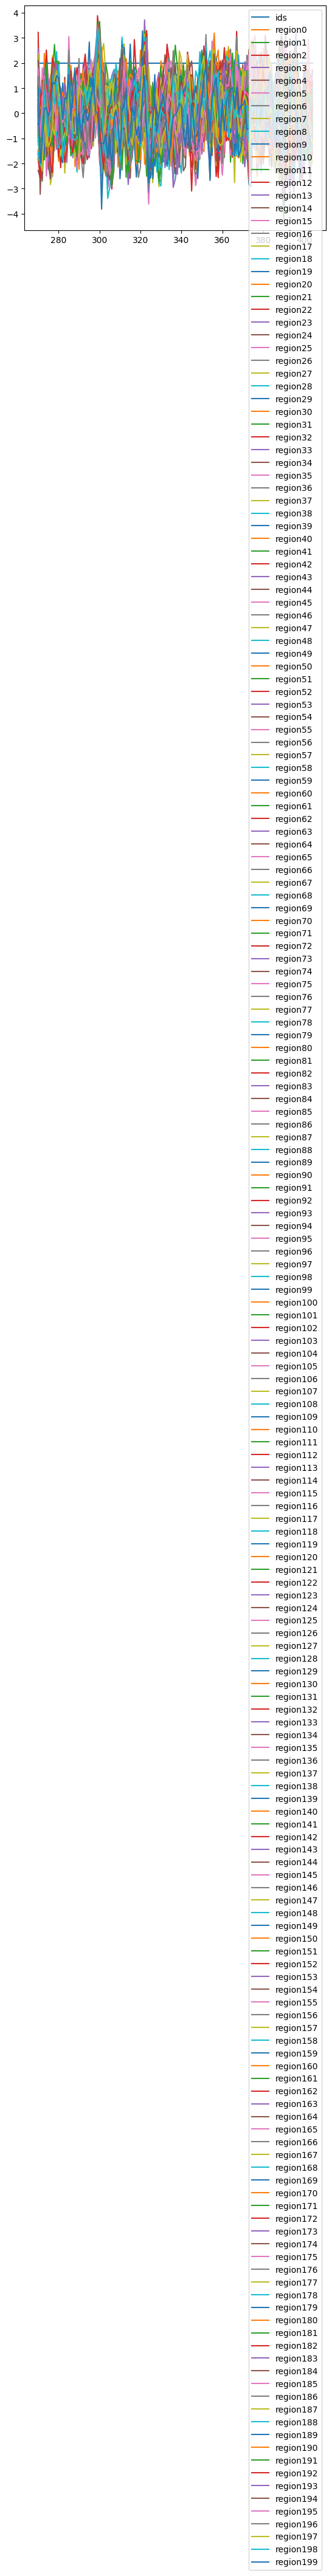

In [ ]:
df_train[df_train.ids == 2].plot()

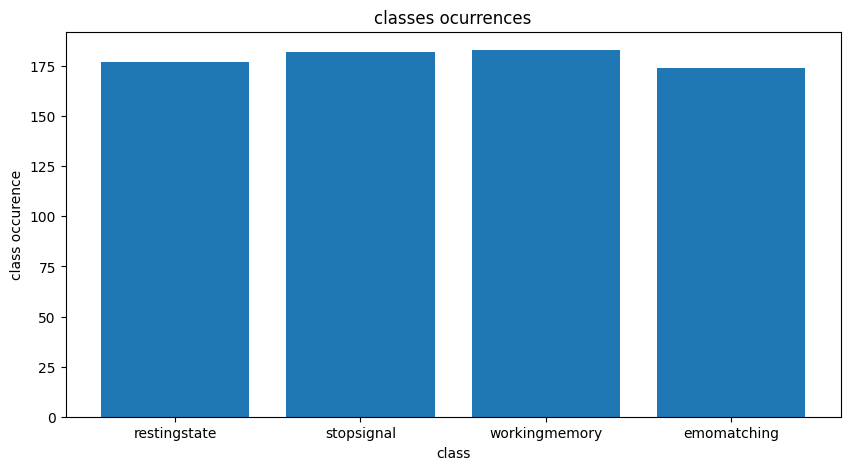

In [ ]:
classes, counts = np.unique(y_train, return_counts=True)
count = {cls: i  for cls, i in zip(classes, counts)}
fig = plt.figure(figsize = (10, 5))
plt.xlabel("class")
plt.ylabel("class occurence")
plt.title("classes ocurrences")
plt.bar([key.split("-")[1] for key in LABELS_DICT.keys()], counts)
plt.show()

In [ ]:
def calculate_features(df):
  return extract_features(
      df[:],
      column_id="ids",
      default_fc_parameters=EfficientFCParameters(),
      column_value="region0", # for now only 1 region is used, to make
  )

In [ ]:
train_features = calculate_features(df_train)
test_features = calculate_features(df_test)

Feature Extraction: 100%|██████████| 180/180 [00:16<00:00, 10.97it/s]


In [ ]:
train_features

,0,1,2,3,4,5,6,7,8,9,...,767,768,769,770,771,772,773,774,775,776
0,1.0,0.0,0.0,0.0,1.776357e-15,135.000000,0.757942,0.023113,0.002835,-0.013822,...,0.749537,1.081972,2.791669,1.696709,2.868085,3.821325,4.476790,4.784587,NaN,2.459178
1,1.0,0.0,0.0,0.0,8.881784e-16,135.000000,0.638338,0.006783,0.011974,-0.029754,...,0.649479,1.014588,2.526388,1.740817,2.986490,4.027663,4.595503,4.806080,NaN,2.268542
2,0.0,0.0,0.0,0.0,-6.159425e+00,134.296845,0.667852,-0.004711,0.004353,-0.019385,...,0.730944,1.143874,2.857356,1.732694,2.926018,3.964169,4.656872,4.838319,NaN,2.274937
3,0.0,0.0,0.0,0.0,1.785071e+00,113.551960,0.718579,-0.017328,0.000378,0.094165,...,0.892268,1.413328,3.266167,1.707224,2.832555,3.850087,4.566126,4.816827,NaN,2.383551
4,1.0,0.0,0.0,0.0,1.356755e+01,143.709962,0.539193,0.013680,-0.006384,-0.010437,...,0.340242,0.651996,2.219721,1.719416,2.865623,3.922456,4.559487,4.802024,NaN,2.536326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0.0,0.0,0.0,0.0,7.138531e+00,131.395905,0.555461,0.008470,0.002904,-0.041712,...,0.504917,0.811473,2.408538,1.684860,2.835615,3.870243,4.480060,4.737545,NaN,2.489260
712,0.0,0.0,0.0,0.0,-3.330669e-16,135.000000,0.663204,-0.018793,0.001103,-0.011330,...,0.340242,0.672383,2.505710,1.768411,2.971254,4.061905,4.635545,4.838319,NaN,2.421682
713,0.0,0.0,0.0,0.0,-8.881784e-16,135.000000,0.656549,0.031671,-0.010566,0.027739,...,0.264491,0.504917,2.131099,1.736768,2.985218,4.130893,4.707577,4.812770,NaN,2.324948
714,1.0,0.0,0.0,0.0,6.099109e+00,157.184293,1.018856,-0.008305,-0.002021,0.139785,...,0.706916,1.345700,3.142594,1.780212,3.121475,4.242640,4.760896,4.859812,NaN,2.385474


In [ ]:
# needed to make lightgbm work
train_features.columns = [i for i in range(train_features.shape[1])]
test_features.columns = [i for i in range(test_features.shape[1])]

In [ ]:
classifier = lgb.LGBMClassifier()
classifier.fit(train_features, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130777
[LightGBM] [Info] Number of data points in the train set: 716, number of used features: 592
[LightGBM] [Info] Start training from score -1.397530
[LightGBM] [Info] Start training from score -1.369673
[LightGBM] [Info] Start training from score -1.364194
[LightGBM] [Info] Start training from score -1.414625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

LGBMClassifier()

In [ ]:
y_pred = classifier.predict(test_features)

In [ ]:
accuracy = accuracy_score(y_test, y_pred, normalize=True)

In [ ]:
print("LightGBM Model accuracy score: {0:0.2f}".format(accuracy))

LightGBM Model accuracy score: 0.82


In [ ]:
from sklearn.metrics import f1_score, precision_score, accuracy_score

def create_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred).astype(np.float64)
  print('f1: ', f1_score(y_test, y_pred, average = None))
  print('precision: ', precision_score(y_test, y_pred, average = None))
  print('accuracy: ', accuracy_score(y_test, y_pred, normalize = True))

  for i in range(cm.shape[0]):
      cm[i, :] /= np.sum(cm[i, :])

  cm_matrix = pd.DataFrame(data=cm)
  label_names = [key.split("-")[1] for key in LABELS_DICT.keys()]
  cm_matrix["types"] = np.array(label_names)

  cm_matrix.set_index("types", inplace=True)
  cm_matrix.columns = label_names

  return cm_matrix

In [ ]:
cm_matrix = create_confusion_matrix(y_test, y_pred)

f1:  [0.70103093 0.66666667 0.9        1.        ]
precision:  [0.68       0.6744186  0.92307692 1.        ]
accuracy:  0.8166666666666667


In [ ]:
def plot_confusion_matrix(cm_matrix):
  plt.figure(figsize=(7, 5))
  sns.heatmap(
      cm_matrix,
      annot=True,
      fmt=".3f",
      square=True,
      cbar=False,
      cmap="Blues",
      linewidths=3,
      vmin=0,
      vmax=1,
  )
  plt.xlabel("Predicted label", labelpad=16)
  plt.ylabel("True label", labelpad=12)
  plt.tick_params(axis="y", rotation=0)
  plt.show()

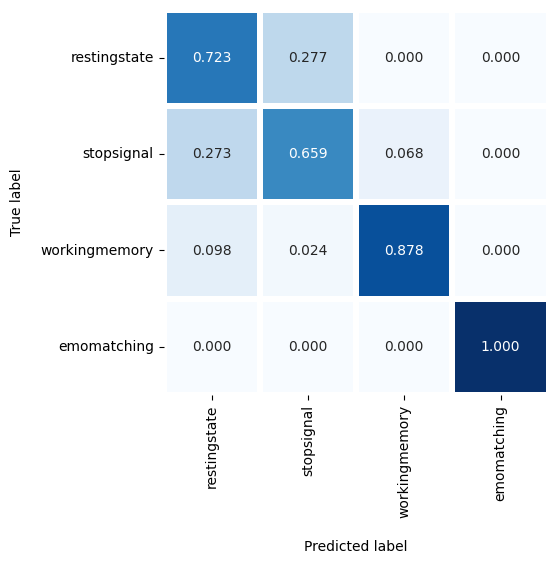

In [ ]:
plot_confusion_matrix(cm_matrix)

In [ ]:
train_cleared = train_features.dropna(axis = 1)
test_cleared = test_features.dropna(axis = 1)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()



train_scaled = scaler.fit_transform(train_cleared.to_numpy())
test_scaled = scaler.transform(test_cleared.to_numpy())
print("Scaled Dataset Using MinMaxScaler")

Scaled Dataset Using MinMaxScaler


In [ ]:
train_scaled.shape

(716, 647)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=647)
pca.fit(train_scaled)

PCA(n_components=647)

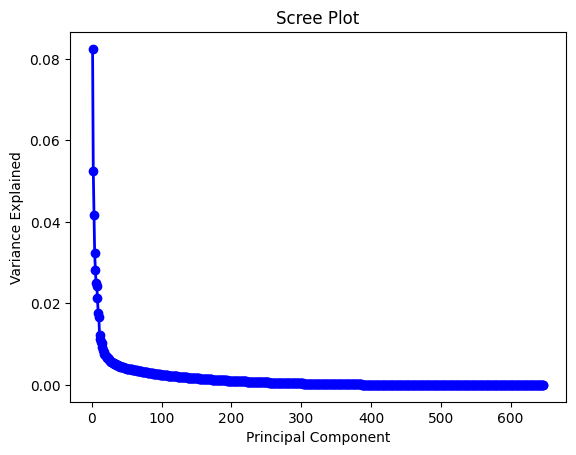

In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

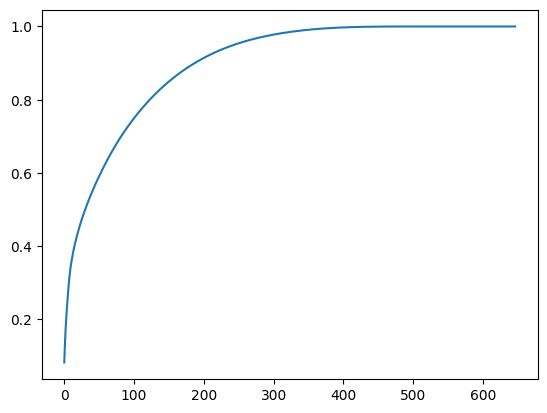

In [ ]:
plt.plot(cumsum)

In [ ]:
d = np.argmax(cumsum >= 0.95) + 1
print(d)

245


In [ ]:
pca = PCA(n_components=245)
train_scaled = pca.fit_transform(train_scaled)
test_scaled = pca.transform(test_scaled)

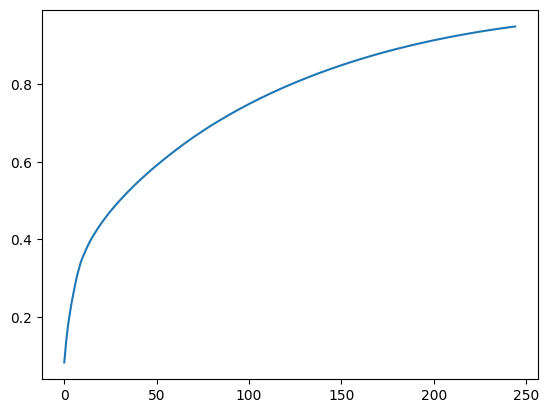

In [ ]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
train_scaled.shape, test_scaled.shape

((716, 245), (180, 245))

In [ ]:
y_train.shape

(716,)

In [ ]:
gnb = GaussianNB()
y_pred = gnb.fit(train_scaled, y_train).predict(test_scaled)

In [ ]:
cm_matrix = create_confusion_matrix(y_test, y_pred)

f1:  [0.56363636 0.42857143 0.88311688 0.85393258]
precision:  [0.49206349 0.45       0.94444444 0.92682927]
accuracy:  0.6722222222222223


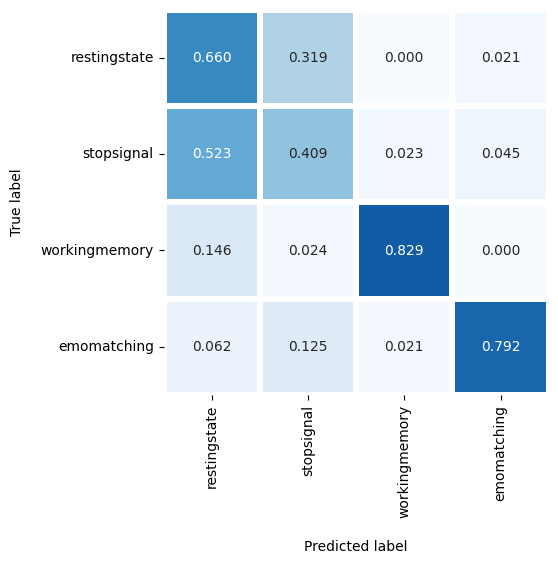

In [ ]:
plot_confusion_matrix(cm_matrix)